In [ ]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.utils.data
import math
import torch.nn.functional as F
from torch.jit import script, trace
from torch import optim
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools

# Processing data

In [ ]:
# data = 'update_data.txt'
data = 'data.txt'
max_len = 25

lines = open(data, 'r', encoding='utf-8').\
        read().strip().split('\n')

print(len(lines))

141


In [ ]:
import re
def normalizeString(s):
    s = s.lower().strip() # chuyển tất cả kí tự thành chữ thường và loại bỏ khoảng trắng đầu cuối
    s = re.sub(r"([.!?])", r" \1", s) # thêm khoảng trắng trước dấu câu
    s = re.sub(r"[^a-zA-ZÀ-ỹ\d.!?]+", r" ", s) # xóa các kí tự đặc biệt và số
    s = re.sub(r"\s+", r" ", s).strip() # xóa khoảng trắng thừa
    return s

In [ ]:
word2index = {}
word2count = {}
num_words = 0
pairs = [normalizeString(i).split(' ') for i in lines]

for sentences in pairs:
    for word in sentences:
        if word not in word2index:
            word2index[word] = num_words
            word2count[word] = 1
            num_words += 1
        else:
            word2count[word] += 1

def trim(min_count, word2count):
    keep_words = {}
    num_word = 0
    for k, v in word2count.items():
        if v >= min_count:
            keep_words[k] = num_word
            num_word += 1

    return keep_words

word2index = trim(min_count=1,word2count=word2count)

word2index['<unk>'] = len(word2index) + 1
word2index['<start>'] = len(word2index) + 1
word2index['<end>'] = len(word2index) + 1
word2index['<pad>'] = 0


In [ ]:
print("Total words are: {}".format(len(word2index)))

Total words are: 471


In [ ]:
def encode_question(words, word_map):
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c


def encode_reply(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + \
    [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

In [ ]:
def trimRateWord(lines, word2index):
    pairs = []
    for i in lines:
        try:
            i = i.strip()
            sentences =i.split('\t')
            question_input = normalizeString(sentences[0]).strip()
            answer_output = normalizeString(sentences[1]).strip()
            keep_input = True
            keep_output = True
            for j in question_input.split(' '):
                if j not in word2index:
                    keep_input = False
                    break
            for j in answer_output.split(' '):
                if j not in word2index:
                    keep_output = False
                    break
            if keep_input and keep_output:
                ques, ans = i.split('\t')
                pairs.append([ques.split(' ')[0:-1], ans.split(' ')[1:]])
        except:
            pass
    return pairs

pairs = trimRateWord(lines=lines,word2index=word2index)
print(pairs[0:5])

[[['Đại', 'học', 'TDTU', 'được', 'thành', 'lập', 'vào', 'năm'], ['Đại', 'học', 'TDTU', 'được', 'thành', 'lập', 'vào', 'năm', '1997.']], [['Khoa', 'nào', 'tại', 'Đại', 'học', 'TDTU', 'nổi', 'tiếng', 'về', 'ngành', 'Công', 'nghệ', 'thông'], ['Công', 'nghệ', 'thông', 'tin', 'tại', 'Đại', 'học', 'TDTU', 'nổi', 'tiếng', 'trong', 'lĩnh', 'vực', 'này.']], [['Đại', 'học', 'TDTU', 'có', 'khuôn', 'viên', 'rộng', 'bao'], ['viên', 'của', 'Đại', 'học', 'TDTU', 'có', 'diện', 'tích', 'khoảng', '100', 'ha.']], [['Đại', 'học', 'TDTU', 'có', 'ký', 'túc', 'xá', 'cho', 'sinh', 'viên', 'ở'], ['Đại', 'học', 'TDTU', 'có', 'ký', 'túc', 'xá', 'để', 'cung', 'cấp', 'chỗ', 'ở', 'cho', 'sinh', 'viên.']], [['Đại', 'học', 'TDTU', 'có', 'chương', 'trình', 'học', 'bổng', 'cho', 'sinh', 'viên'], ['Đại', 'học', 'TDTU', 'cung', 'cấp', 'nhiều', 'chương', 'trình', 'học', 'bổng', 'cho', 'sinh', 'viên', 'xuất', 'sắc.']]]


In [ ]:
pairs_encoded = []
for pair in pairs:
    qus = encode_question(pair[0], word2index)
    ans = encode_reply(pair[1], word2index)
    pairs_encoded.append([qus, ans])


In [ ]:
q_a_encodeed = []
for i in pairs_encoded:
    if len(i[1]) != 27 or len(i[0]) != 25:
        continue
    q_a_encodeed.append(i)

print(q_a_encodeed)

with open('pairs_encoded.json', 'w') as p:
    json.dump(q_a_encodeed[:100], p)

with open('val_data.json', 'w') as p:
    json.dump(q_a_encodeed[100:], p)

[[[468, 1, 468, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [469, 468, 1, 468, 3, 4, 5, 6, 7, 468, 470, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[468, 8, 20, 468, 1, 468, 21, 22, 23, 24, 468, 26, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [469, 468, 26, 27, 28, 20, 468, 1, 468, 21, 22, 29, 30, 31, 468, 470, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[468, 1, 468, 12, 42, 43, 44, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [469, 43, 45, 468, 1, 468, 12, 46, 47, 48, 49, 468, 470, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[468, 1, 468, 12, 51, 52, 53, 54, 55, 43, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [469, 468, 1, 468, 12, 51, 52, 53, 58, 59, 60, 61, 56, 54, 55, 468, 470, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[468, 1, 468, 12, 33, 34, 1, 62, 54, 55, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [469, 468, 1, 468, 59, 60, 63, 33, 34, 1, 62, 54, 55, 43, 64, 468, 470, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[468, 8, 20, 468, 1, 468, 66, 23, 24, 468, 68, 1

In [ ]:
class Dataset(Dataset):

    def __init__(self):

        self.pairs = json.load(open('pairs_encoded.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):

        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])

        return question, reply

    def __len__(self):
        return self.dataset_size


class ValDataset(Dataset):

    def __init__(self):

        self.pairs = json.load(open('val_data.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):

        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])

        return question, reply

    def __len__(self):
        return self.dataset_size

In [ ]:
train_loader = torch.utils.data.DataLoader(Dataset(),
                                           batch_size = 40,
                                           shuffle=True,
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(ValDataset(),
                                           batch_size = 40,
                                           shuffle=True,
                                           pin_memory=True)

In [ ]:
def create_masks(question, reply_input, reply_target):

    def subsequent_mask(size):
        mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        return mask.unsqueeze(0)

    question_mask = question!=0
    question_mask = question_mask.to(device)
    question_mask = question_mask.unsqueeze(1).unsqueeze(1)         # (batch_size, 1, 1, max_words)

    reply_input_mask = reply_input!=0
    reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words)
    reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data)
    reply_input_mask = reply_input_mask.unsqueeze(1) # (batch_size, 1, max_words, max_words)
    reply_target_mask = reply_target!=0              # (batch_size, max_words)

    return question_mask, reply_input_mask, reply_target_mask

# Define Model

# Transformer


In [ ]:
class Embeddings(nn.Module):
    """
    Implements embeddings of the words and adds their positional encodings.
    """
    def __init__(self, vocab_size, d_model, max_len = 50, num_layers = 6):
        super(Embeddings, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = self.create_positinal_encoding(max_len, self.d_model)     # (1, max_len, d_model)
        self.te = self.create_positinal_encoding(num_layers, self.d_model)  # (1, num_layers, d_model)
        self.dropout = nn.Dropout(0.1)

    def create_positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model).to(device)
        for pos in range(max_len):   # for each position of the word
            for i in range(0, d_model, 2):   # for each dimension of the each position
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)   # include the batch size
        return pe

    def forward(self, embedding, layer_idx):
        if layer_idx == 0:
            embedding = self.embed(embedding) * math.sqrt(self.d_model)
        embedding += self.pe[:, :embedding.size(1)]   # pe will automatically be expanded with the same batch size as encoded_words
        # embedding: (batch_size, max_len, d_model), te: (batch_size, 1, d_model)
        embedding += self.te[:, layer_idx, :].unsqueeze(1).repeat(1, embedding.size(1), 1)
        embedding = self.dropout(embedding)
        return embedding

### MultiHeadAttention



In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, heads, d_model):

        super(MultiHeadAttention, self).__init__()
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = nn.Dropout(0.1)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, 512)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, 512)
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        # (batch_size, max_len, 512) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)

        # Tính attention score
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0,1,3,2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask == 0, -1e9)    # (batch_size, h, max_len, max_len)
        weights = F.softmax(scores, dim = -1)           # (batch_size, h, max_len, max_len)
        weights = self.dropout(weights)
        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)
        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, h * d_k)
        context = context.permute(0,2,1,3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)
        # (batch_size, max_len, h * d_k)
        interacted = self.concat(context)
        return interacted

### FeedForward


In [ ]:
class FeedForward(nn.Module):

    def __init__(self, d_model, middle_dim = 2048):
        super(FeedForward, self).__init__()

        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

In [ ]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

In [ ]:
class DecoderLayer(nn.Module):

    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.src_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, embeddings, encoded, src_mask, target_mask):
        query = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, target_mask))
        query = self.layernorm(query + embeddings)
        interacted = self.dropout(self.src_multihead(query, encoded, encoded, src_mask))
        interacted = self.layernorm(interacted + query)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        decoded = self.layernorm(feed_forward_out + interacted)
        return decoded

In [ ]:
class Transformer(nn.Module):

    def __init__(self, d_model, heads, num_layers, word_map):
        super(Transformer, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.vocab_size = len(word_map)
        self.embed = Embeddings(self.vocab_size, d_model, num_layers = num_layers)
        self.encoder = EncoderLayer(d_model, heads)
        self.decoder = DecoderLayer(d_model, heads)
        self.logit = nn.Linear(d_model, self.vocab_size)

    def encode(self, src_embeddings, src_mask):
        for i in range(self.num_layers):
            src_embeddings = self.embed(src_embeddings, i)
            src_embeddings = self.encoder(src_embeddings, src_mask)
        return src_embeddings

    def decode(self, tgt_embeddings, target_mask, src_embeddings, src_mask):
        for i in range(self.num_layers):
            tgt_embeddings = self.embed(tgt_embeddings, i)
            tgt_embeddings = self.decoder(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings

    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out

In [ ]:
class AdamWarmup:

    def __init__(self, model_size, warmup_steps, optimizer):

        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0

    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))

    def step(self):
        # Increment the number of steps each time we call the step function
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        # update the learning rate
        self.lr = lr
        self.optimizer.step()

In [ ]:
class LossWithLS(nn.Module):

    def __init__(self, size, smooth):
        super(LossWithLS, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False, reduce=False)
        self.confidence = 1.0 - smooth
        self.smooth = smooth
        self.size = size

    def forward(self, prediction, target, mask):
        """
        prediction of shape: (batch_size, max_words, vocab_size)
        target and mask of shape: (batch_size, max_words)
        """
        prediction = prediction.view(-1, prediction.size(-1))   # (batch_size * max_words, vocab_size)
        target = target.contiguous().view(-1)   # (batch_size * max_words)
        mask = mask.float()
        mask = mask.view(-1)       # (batch_size * max_words)
        labels = prediction.data.clone()
        labels.fill_(self.smooth / (self.size - 1))
        labels.scatter_(1, target.data.unsqueeze(1), self.confidence)
        loss = self.criterion(prediction, labels)    # (batch_size * max_words, vocab_size)
        loss = (loss.sum(1) * mask).sum() / mask.sum()
        return loss

In [ ]:
d_model = 512
heads = 8
num_layers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 2000

word_map = word2index


transformer = Transformer(d_model = d_model, heads = heads, num_layers = num_layers, word_map = word_map)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.2)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
history = []
val = []
def train(train_loader, transformer, criterion, epoch, flag=True):

    transformer.train()
    sum_loss = 0
    count = 0


    for i, (question, reply) in enumerate(train_loader):

        samples = question.shape[0]

        # Move to device
        question = question.to(device)
        reply = reply.to(device)

        # Prepare Target Data
        reply_input = reply[:, :-1]
        reply_target = reply[:, 1:]

        # Create mask and add dimensions
        question_mask, reply_input_mask, reply_target_mask = create_masks(question, reply_input, reply_target)

        # Get the transformer outputs
        out = transformer(question, question_mask, reply_input, reply_input_mask)

        # Compute the loss
        loss = criterion(out, reply_target, reply_target_mask)

        # Backprop
        transformer_optimizer.optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()

        sum_loss += loss.item() * samples
        count += samples

        if i % 100 == 0:
            if flag:
                history.append(sum_loss/count)
            else:
                val.append(sum_loss/count)
            if epoch % 100 == 0 or epoch == epochs - 1:
              print("Epoch [{}][{}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), sum_loss/count))


In [ ]:
def evaluate(transformer, question, question_mask, max_len, word_map):
    """
    Performs Greedy Decoding with a batch size of 1
    """
    rev_word_map = {v: k for k, v in word_map.items()}
    transformer.eval()
    start_token = word_map['<start>']
    encoded = transformer.encode(question, question_mask)
    words = torch.LongTensor([[start_token]]).to(device)

    for step in range(max_len - 1):
        size = words.shape[1]
        target_mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        target_mask = target_mask.to(device).unsqueeze(0).unsqueeze(0)
        decoded = transformer.decode(words, target_mask, encoded, question_mask)
        predictions = transformer.logit(decoded[:, -1])
        _, next_word = torch.max(predictions, dim = 1)
        next_word = next_word.item()
        if next_word == word_map['<end>']:
            break
        words = torch.cat([words, torch.LongTensor([[next_word]]).to(device)], dim = 1)   # (1,step+2)

    # Construct Sentence
    if words.dim() == 2:
        words = words.squeeze(0)
        words = words.tolist()

    sen_idx = [w for w in words if w not in {word_map['<start>']}]
    sentence = ' '.join([rev_word_map[sen_idx[k]] for k in range(len(sen_idx))])

    return sentence

In [ ]:
for epoch in range(epochs):
    train(train_loader, transformer, criterion, epoch)
    train(val_loader, transformer, criterion, epoch,flag=False)
    state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
    if epoch %  500 == 0 or epoch == epochs - 1:
      torch.save(state, f'checkpoint_{epoch}.pth.tar')

Epoch [0][0/3]	Loss: 4.907
Epoch [0][0/1]	Loss: 4.747
Epoch [100][0/3]	Loss: 0.911
Epoch [100][0/1]	Loss: 0.347
Epoch [200][0/3]	Loss: 0.179
Epoch [200][0/1]	Loss: 0.111
Epoch [300][0/3]	Loss: 0.114
Epoch [300][0/1]	Loss: 0.051
Epoch [400][0/3]	Loss: 0.071
Epoch [400][0/1]	Loss: 0.033
Epoch [500][0/3]	Loss: 0.051
Epoch [500][0/1]	Loss: 0.021
Epoch [600][0/3]	Loss: 0.075
Epoch [600][0/1]	Loss: 0.028
Epoch [700][0/3]	Loss: 0.059
Epoch [700][0/1]	Loss: 0.016
Epoch [800][0/3]	Loss: 0.068
Epoch [800][0/1]	Loss: 0.038
Epoch [900][0/3]	Loss: 0.068
Epoch [900][0/1]	Loss: 0.013
Epoch [1000][0/3]	Loss: 0.054
Epoch [1000][0/1]	Loss: 0.031
Epoch [1100][0/3]	Loss: 0.039
Epoch [1100][0/1]	Loss: 0.011
Epoch [1200][0/3]	Loss: 0.049
Epoch [1200][0/1]	Loss: 0.013
Epoch [1300][0/3]	Loss: 0.052
Epoch [1300][0/1]	Loss: 0.009
Epoch [1400][0/3]	Loss: 0.045
Epoch [1400][0/1]	Loss: 0.012
Epoch [1500][0/3]	Loss: 0.045
Epoch [1500][0/1]	Loss: 0.016
Epoch [1600][0/3]	Loss: 0.089
Epoch [1600][0/1]	Loss: 0.036
Epoc

In [ ]:
checkpoint = torch.load('checkpoint_{}.pth.tar'.format(epochs - 1))
transformer = checkpoint['transformer']

# Inference model

In [ ]:
while(True):
    question = input("Question: ")
    if question == 'STOP' or question == 'stop':
        break
    max_len = 15
    question = normalizeString(question)
    enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
    question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)
    sentence = evaluate(transformer, question, question_mask, int(max_len), word_map).split(' ')
    sentence[:] = [x for x in sentence if x != '<unk>']
    print('Bot: ', ' '.join(sentence))

Question: tdtu rộng bao nhiêu
Bot:  viên của học có diện tích khoảng 100
Question: tdtu có bao nhiêu cơ sở
Bot:  có 4 cơ sở tại và
Question: stop


# Early stopping

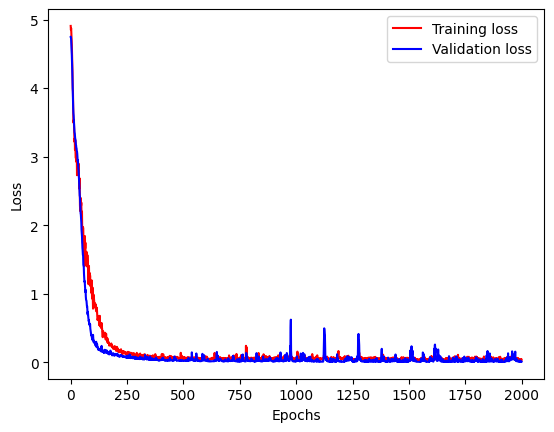

In [ ]:
import matplotlib.pyplot as plt

plot_epochs = range(0, 2000)
plt.plot(plot_epochs, history, 'r', label='Training loss')
plt.plot(plot_epochs, val, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# BLEU Score


In [ ]:
test_data = []
with open(data, 'r') as f:
    line = f.readline()
    while line:
        if(line == "\n"):
          line = f.readline()
          continue
        temp =  line.split('\t')
        if ("" in temp):
          temp.remove("")
        question = temp[0]
        answer = temp[1]
        test_data.append((question.strip(), answer.replace('\n', '').strip()))
        line = f.readline()

test_data = test_data[5000:]
question = [i[0] for i in test_data]
answers = [i[1] for i in test_data]
references = [i.split(" ") for i in answers]


In [ ]:
pred = []
for ques in question:
    max_len = 15
    question_i = normalizeString(ques)
    enc_qus = [word_map.get(word, word_map['<unk>']) for word in question_i.split()]
    question_i = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
    question_mask = (question_i!=0).to(device).unsqueeze(1).unsqueeze(1)
    sentence = evaluate(transformer, question_i, question_mask, int(max_len), word_map).split(' ')
    sentence[:] = [x for x in sentence if x != '<unk>']
    pred.append(' '.join(sentence))

pred = [i.split(" ") for i in pred]

In [ ]:
from torchtext.data.metrics import bleu_score

score = bleu_score(pred, references, max_n=1, weights=[1])
print(score)

0.0
